# Automatic labelling of radiology reports

In [16]:
# Library imports

# General
import sys
import os
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
from datetime import datetime

# NLP imports
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
import re

# sklearn
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix

# gensim for word embedding featurization
import gensim
from collections import namedtuple

# misc
import glob
import os.path
import multiprocessing
import random
import umap.umap_ as umap
import matplotlib.pyplot as plt
import pickle
import shelve
from itertools import groupby
import collections

sys.path.append("C:\\Users\\marti\\Dropbox\\1. KCL\\1. Current Modules\\6. SPM\\1. Analysis\\NLP\\rad-report-annotator")
sys.path.append("C:\\Users\\marti\\Dropbox\\1. KCL\\1. Current Modules\\6. SPM\\1. Analysis\\NLP\\roc_comparison-master")

import RadReportAnnotator as ra
from compare_auc_delong_xu import delong_roc_variance
# pd.set_option('display.max_columns', None)
# dir(RadReportAnnotator) # list available functions

In [2]:
# Initialize some folder paths
reports = "C:\\Users\\marti\\Dropbox\\1. KCL\\1. Current Modules\\6. SPM\\1. Analysis\\NLP\\Data\\20080801 20190131 Neuro and SLAM MRI Heads.csv"
reports_path = "C:\\Users\\marti\\Dropbox\\1. KCL\\1. Current Modules\\6. SPM\\1. Analysis\\NLP\\Data\\Reports"

test_labels = "C:\\Users\\marti\\Dropbox\\1. KCL\\1. Current Modules\\6. SPM\\1. Analysis\\NLP\\Data\\output_test.xlsx"
binary_labels = "C:\\Users\\marti\\Dropbox\\1. KCL\\1. Current Modules\\6. SPM\\1. Analysis\\NLP\\Data\\output_binary_combined.xlsx" # note that in binary_labels the label "mass" was used to identify abnormal vs normal
stroke_labels = "C:\\Users\\marti\\Dropbox\\1. KCL\\1. Current Modules\\6. SPM\\1. Analysis\\NLP\\Data\\output_stroke_20191210.xlsx"
labels_path = "C:\\Users\\marti\\Dropbox\\1. KCL\\1. Current Modules\\6. SPM\\1. Analysis\\NLP\\Data\\Labels"
figures_path = "C:\\Users\\marti\\Dropbox\\1. KCL\\1. Current Modules\\6. SPM\\1. Analysis\\NLP\\Data\\Figures"
sessions_path = "C:\\Users\\marti\\Dropbox\\1. KCL\\1. Current Modules\\6. SPM\\1. Analysis\\NLP\\Data\\Sessions"
results_path = "C:\\Users\\marti\\Dropbox\\1. KCL\\1. Current Modules\\6. SPM\\1. Analysis\\NLP\\Data\\Results"

labels = binary_labels # use either test_labels or binary_labels for now

if labels == stroke_labels: current_labels = 'stroke'
if labels == binary_labels: current_labels = 'abnormal'
if labels == test_labels: current_labels = 'test'

In [3]:
# Create pandas dataframes
df_raw = pd.read_csv(reports,encoding = "ISO-8859-1", dtype={"Code": 'O',}) # Column 17 "Code" reports a mixed value error on import without specifying it as Python Object 
df_labels = pd.read_excel(labels) 

In [4]:
# Remove NaN, <18 yo, and brief reports.
df_raw = df_raw[~df_raw["Report Text"].isnull()] # remove the lines with missing reports
df_raw = df_raw[~df_raw['DOB'].isnull()] # remove missing DOB
df_raw = df_raw[df_raw['Report Text'].map(len) > 10] # include reports with length greater than
df_raw = df_raw[(df_raw['Event Year'].astype(int) - df_raw['DOB'].str[-4:].astype(int))>18] # remove under 18
df_raw = df_raw.reset_index()

#df_raw.head()
# dob_mask.head(50)

In [5]:
# Replicate the format of Sinai data, but use csv - this means we can't use all of their code
# Sinai code uses XLS, so would have to cap df_raw_filter to some smaller subset

# print(df_raw.columns)
df_raw_filter = df_raw.loc[:,["Accession", "Report Text"]]
df_raw_filter.columns=["Accession Number", "Report Text"]
df_raw_filter.to_csv(reports_path+'\\raw_data_filtered.csv',header = True, index = False)
reports_filter = reports_path+'\\raw_data_filtered.csv'


In [6]:
filter_columns = [' Accession ', ' Fazekas ', ' Supratentorial Atrophy ',
        ' Infratentorial Atrophy ', ' Mass ', ' Vascular ', ' Damage ',
        ' Acute Stroke ', ' Haemorrhage ', ' Hydrocephalus ',
        ' White Matter Inflammation ', ' Foreign Body ', ' Intracranial ',
        ' Extracranial '] # select accession and other variables
df_labels_filter = df_labels[filter_columns] 
df_labels_filter = df_labels_filter.rename(columns = {' Accession ':'Accession Number'}) # rename to match the other file

# We can use excel for this one bc # of labels will always < 65k. Also, build_train_test_corpus requires xls
# df_labels_filter["Accession Number"] = df_labels_filter.loc[:,"Accession Number"].str[3:]
df_labels_filter.to_excel(labels_path+'\\labels_filtered.xls',header = True, index = False)
labels_filter = labels_path+'\\labels_filtered.xls'

In [7]:
# this is a replacement of the get_label_indeces function
# ra.get_labeled_indices(reports_path, labels_filter, train_index_override)
label_ids = df_labels_filter['Accession Number']
mask_labels = df_raw_filter['Accession Number'].isin(label_ids.tolist()) # true/false for the ones in the list

In [8]:
# Create a list of stopwords and process data
stop_words = set(stopwords.words('english')) # could add MRI etc to this
preprocessed = ra.preprocess_data(df_raw_filter,stop_words, stem_words=True) # can change to false with d2v, but didn't seem to help

  0%|                                     | 56/108602 [00:00<03:17, 548.99it/s]

preprocessing reports


100%|█████████████████████████████████| 108602/108602 [03:31<00:00, 512.69it/s]


### Build Corpus

In [9]:
# Create n-grams  
N_THRESH_CORPUS = 10 # ignore any n-grams that appear fewer than N times in the entire corpus
n_gram_sizes = [1,2,3,4] # need to make sure we can use 4 - their examples are 3 max 
ngram_list = ra.create_ngrams(preprocessed, mask_labels, n_gram_sizes, N_THRESH_CORPUS)

## notes from david: set n_gram = 1 for gensim

  0%|                                   | 309/108602 [00:00<00:35, 3089.83it/s]

creating n-grams


100%|████████████████████████████████| 108602/108602 [00:27<00:00, 4007.22it/s]


number of unique n-grams: 4282825
number of unique n-grams after filtering out low frequency tokens: 146163


In [10]:
# Split the sets for training & testing
# Note that this function requires xls for label file
# This can take a while - could add an indicator in the future

TRAIN_INDEX_OVERRIDE = [0] # This would be a list of indices for which to ignore the labels if all of the training data was labelled
corpus, train_corpus, test_corpus, dictionary, labeled_indices = ra.build_train_test_corpus(df_raw_filter, ngram_list, labels_filter, TRAIN_INDEX_OVERRIDE)

### Characterize the corpus

In [41]:
# Characterize the corpus - adapted from https://swizec.com/blog/measuring-vocabulary-richness-with-python/swizec/2528
def get_yules(tokens):
    token_counter = collections.Counter(tok.upper() for tok in tokens)
    m1 = sum(token_counter.values())
    m2 = sum([freq ** 2 for freq in token_counter.values()])
    i = (m1*m1) / (m2-m1)
    k = 1/i * 10000
    return (k, i)

In [31]:
# Flatten the list of lists into a list for complexity analysis
flat_preprocessed = []
for sublist in preprocessed:
    for item in sublist:
        flat_preprocessed.append(item)

In [42]:
k, i = get_yules(flat_preprocessed)
unique_words = collections.Counter(flat_preprocessed).keys()

In [47]:
from nltk.corpus import twitter_samples, reuters, gutenberg 

In [53]:
print(twitter_samples)

<TwitterCorpusReader in 'C:\\Users\\marti\\AppData\\Roaming\\nltk_data\\corpora\\twitter_samples'>


In [43]:
print('Yule I:',i)
print('Yule K:',k)
print('Unique tokens:',len(unique_words))
#yule_corpus = get_yules(corpus)
#print(yule_corpus)
print('Total tokens:', len(flat_preprocessed))
print('TTR:', len(unique_words)/len(flat_preprocessed))

Yule I: 47.38222603541919
Yule K: 211.04960312596532
Unique tokens: 33770
Total tokens: 8182337
TTR: 0.004127182735201447


# SORT THIS OUT?

In [62]:
# I'm pretty sure "d2v_inputs" is the same as "preprocessed" but generate_labeled_data_features requires both,
# and I can't really tell how they're different

d2v_inputs = ra.remove_infrequent_tokens(preprocessed, N_THRESH_CORPUS, mask_labels)

In [64]:
# Create training sets
unlabeled_corpus, labeled_corpus, total_unlabeled_words = ra.build_d2v_corpora(df_raw_filter, preprocessed,labeled_indices)

106610 unlabeled reports for featurization, 1992 labeled reports for modeling


In [71]:
# Establish variables
D2V_EPOCHS = 20 # recommended by Sinai
DIM_DOC2VEC = 50 # Dimensionality of doc2vec manifold; recommend value in 50 to 400
W2V_DM = 1
W2V_WINDOW = 3
SILVER_THRESHOLD = "mean" # can be ["mean","mostlikely"]
DO_PARAGRAPH_VECTOR = False # True to use word2vec-based paragraph vector embedding fatures
DO_BOW = True
DO_WORD2VEC = False  # True to use word2vec-based average word embedding fatures
N_THRESH_OUTCOMES = 100 # do not train models for labels that don't have at least this many positive and negative examples
pred_type = "combined" # a label for results
ASSIGNFOLD_USING_ROW=False
SILVER_THRESHOLD="fiftypct"

if DO_PARAGRAPH_VECTOR == True: model_name = 'd2v'
if DO_BOW == True: model_name = 'BOW'
if DO_WORD2VEC == True: model_name = 'w2v'

if(DO_BOW and DO_WORD2VEC and DO_PARAGRAPH_VECTOR): model_name= 'all'
if(DO_BOW and DO_WORD2VEC and not DO_PARAGRAPH_VECTOR): model_name = 'bow_w2v'
if(DO_BOW and not DO_WORD2VEC and DO_PARAGRAPH_VECTOR): model_name = 'bow_d2v'
if(not DO_BOW and DO_WORD2VEC and DO_PARAGRAPH_VECTOR): model_name = 'w2v_d2v'



In [66]:
def train_d2v(unlabeled_docs, labeled_docs, D2V_EPOCH, DIM_DOC2VEC, W2V_DM, W2V_WINDOW, total_unlabeled_words):
	"""
	Train doc2vec/word2vec model.
	Args:
		unlabeled_docs: unlabeled corpus
		labeled_docs: labeled corpus
		D2V_EPOCHS: number of epochs to train d2v model; 20 has worked well in our experiments; parameter for gensim doc2vec
		DIM_DOC2VEC: dimensionality of embedding vectors, we explored values 50-800; parameter for gensim doc2vec
		W2V_DM: 1 is PV-DM, otherwise PV-DBOW; parameter for gensim doc2vec
		W2V_WINDOW: number of words window to use  in doc2vec model; parameter for gensim doc2vec
		total_unlabeled_words: total words in unlabeled corpus; argument for gensim doc2vec
	Returns:
		d2vmodel: trained doc2vec model.
	"""

	cores = multiprocessing.cpu_count()
	assert gensim.models.doc2vec.FAST_VERSION > -1, "speed up"
	print("started doc2vec training")
	d2vmodel = gensim.models.Doc2Vec(dm=W2V_DM, size=DIM_DOC2VEC, window=W2V_WINDOW, negative=5, hs=0, min_count=2, workers=cores)
	d2vmodel.build_vocab(unlabeled_docs + labeled_docs)  
	d2vmodel.train(unlabeled_docs, total_words=total_unlabeled_words, epochs=D2V_EPOCH)
	print("finished doc2vec training")
	return d2vmodel

In [67]:
# Train
d2vmodel = train_d2v(unlabeled_corpus, labeled_corpus, D2V_EPOCHS, DIM_DOC2VEC, 
                        W2V_DM, W2V_WINDOW, total_unlabeled_words)

started doc2vec training


c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


finished doc2vec training


In [72]:
# Create features for Lasso log reg
bow_matrix, pv_matrix, w2v_matrix, accid_list, orig_text, orig_input = ra.generate_labeled_data_features(labels_filter,labeled_indices,
                                                                                                         DIM_DOC2VEC, df_raw_filter,  
                                                                                                         preprocessed, DO_PARAGRAPH_VECTOR, 
                                                                                                         DO_WORD2VEC, dictionary, 
                                                                                                         corpus, d2vmodel, d2v_inputs)


 11%|████                                 | 219/1992 [00:00<00:00, 2189.88it/s]

generating features


100%|████████████████████████████████████| 1992/1992 [00:00<00:00, 2101.15it/s]


In [73]:
# Generate dataframe of labels to be used in Lasso logistic regressions
# EDITED range in for loop to skip the IDs as variables; removed IDs right after loop
def generate_outcomes(labeled_file, accid_list, N_THRESH_OUTCOMES):

    """
    Generate dataframe of labels to be used in Lasso logistic regressions
    Args:
        labeled_file: path to file with labels and accession ids
        accid_list: list of accession ids of each row in the labeled data that are also present in exported reports; 
                    needed to eliminate labeled reports for which we have no text (mistranscribed accession IDs, etc.)
        N_THRESH_OUTCOMES: eliminate outcomes that don't have this many positive / negative examples
    Returns:
        eligible_outcomes_aligned: dataframe of labels eligible for prediction
        all_outcomes_aligned: dataframe of all labels
        N_LABELS: total number of labels we predict
        outcome_header_list: list of headers corresponding to each label
    """    
    outcomes = pd.read_excel(labeled_file)
    outcomes.set_index('Accession Number')
    outcomes_aligned2 = pd.DataFrame(data=accid_list, index=accid_list, columns=['Accession Number'])
    all_outcomes_aligned = pd.merge(outcomes_aligned2, outcomes, sort=False)

    N_LABELS = all_outcomes_aligned.shape[1]
    outcome_remove=[]
    print('total labels:'+str(N_LABELS))

    for i in range(1,N_LABELS): #start from 1 to skip the IDs
        check=sum(all_outcomes_aligned.iloc[:,i])

        if(check<N_THRESH_OUTCOMES):
            outcome_remove.append(i)
        elif(check>((all_outcomes_aligned.shape)[0]-N_THRESH_OUTCOMES)):
            outcome_remove.append(i)
        elif(math.isnan(check)):
            outcome_remove.append(i)

    outcome_remove.append(0) # added this to remove the accession IDs as "outcomes"
    eligible_outcomes_aligned=all_outcomes_aligned.drop(all_outcomes_aligned.columns[outcome_remove],axis=1)

    N_LABELS=eligible_outcomes_aligned.shape[1]
    print("labels eligible for inference:"+str(N_LABELS))

    outcome_header_list=list(eligible_outcomes_aligned)
    outcome_header_list=[x.replace(",",".") for x in outcome_header_list]
    outcome_header_list=",".join(outcome_header_list)

    return eligible_outcomes_aligned,all_outcomes_aligned, N_LABELS, outcome_header_list

In [74]:
# Create input for Lasso
eligible_outcomes_aligned, all_outcomes_aligned, N_LABELS, outcome_header_list = generate_outcomes(labels_filter, 
                                                                                              accid_list, N_THRESH_OUTCOMES)

total labels:14
labels eligible for inference:1


In [75]:
# initiate predictor_matrix before generating silver standard labels -- use whatever features are generated (word2vec average word embeddings, bow features, paragraph vector matrix)
if(DO_BOW and DO_WORD2VEC and DO_PARAGRAPH_VECTOR): combined=np.hstack((bow_matrix,w2v_matrix,pv_matrix))

if(DO_BOW and DO_WORD2VEC and not DO_PARAGRAPH_VECTOR): combined=np.hstack((bow_matrix,w2v_matrix))
if(DO_BOW and not DO_WORD2VEC and DO_PARAGRAPH_VECTOR): combined=np.hstack((bow_matrix,pv_matrix))
if(not DO_BOW and DO_WORD2VEC and DO_PARAGRAPH_VECTOR): combined=np.hstack((w2v_matrix,pv_matrix))

if(DO_BOW and not DO_WORD2VEC and not DO_PARAGRAPH_VECTOR): combined=bow_matrix
if(not DO_BOW and DO_WORD2VEC and not DO_PARAGRAPH_VECTOR): combined=w2v_matrix
if(not DO_BOW and not DO_WORD2VEC and DO_PARAGRAPH_VECTOR): combined=pv_matrix		

predictor_matrix = combined

headers=[]
if(DO_BOW): 				headers=headers + [dictionary[i] for i in dictionary]
if(DO_WORD2VEC): 			headers=headers + ["W2V"+str(i) for i in range(0,DIM_DOC2VEC)]
if(DO_PARAGRAPH_VECTOR): 	headers=headers + ["PV"+str(i) for i in range(0,DIM_DOC2VEC)]
    

In [76]:
# Export matrices for reloading if needed
# pd.DataFrame(predictor_matrix).to_csv(sessions_path+'\\w2v_matrix_'+datetime.now().strftime("%Y%m%d%H%M%S")+'.csv',header = True, index = False)
# eligible_outcomes_aligned.to_csv(reports_path+'\\eligible_outcomes_aligned.csv',header= True, index = False)
# predictor_matrix = pd.read_csv(sessions_path+'\\bow_matrix_20191208084113.csv')

# variable_filename=sessions_path+'variables_'+datetime.now().strftime("%Y%m%d%H%M%S")+'.out'


# my_shelf = shelve.open(variable_filename,'n')

# for key in dir():
#     try:
#         my_shelf[key] = globals()[key]
#     except:
#         #
#         # __builtins__, my_shelf, and imported modules can not be shelved.
#         #
#         print('ERROR shelving: {0}'.format(key))
# my_shelf.close()

# Simplified classifier

In [77]:
# pick just the acute stroke variable for now
# eligible_outcomes_aligned = eligible_outcomes_aligned[' Acute Stroke ']
# eligible_outcomes_aligned = eligible_outcomes_aligned[[' Acute Stroke ']].copy()

pandas.core.frame.DataFrame

In [79]:
# Split the data and keep constant between reruns

test_size = 0.2 # proportion of all labeled data set aside for testing
test_rng_seed = 90

X = predictor_matrix
Y = eligible_outcomes_aligned.to_numpy(dtype=int) 
Y = Y.ravel()

# rng_test = np.random.RandomState(test_rng_seed)
# train_indices = rng_test.randint(0,len(Y),len(Y))
# len(train_indices)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, random_state = test_rng_seed)

In [80]:
print("Grid searching...")
max_iter = 1000 # used 1000 to avoid grid search convergence warnings with word2vec (larger dimensionality requires 4000+ iterations)

# Tried a BOW split for l1 but results were worse
# if DO_BOW == True:
#     parameters = { "penalty": ['l1'], 
#            "C": [64,32,16,8,4,2,1,0.5,0.25,0.1,0.05,0.025,0.01,0.005]}
#     cv = StratifiedKFold(n_splits=5)
#     grid_search = GridSearchCV(LogisticRegression(solver='liblinear', max_iter = max_iter), param_grid=parameters, scoring='neg_log_loss', cv=cv)
#     grid_search.fit(X_train,np.array(Y_train))				
#     best_parameters0 = grid_search.best_estimator_.get_params()
#     classifier = LogisticRegression(**best_parameters0)
# else:

parameters = { "penalty": ['l2'], 
       "C": [64,32,16,8,4,2,1,0.5,0.25,0.1,0.05,0.025,0.01,0.005]}
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter = max_iter), param_grid=parameters, scoring='neg_log_loss', cv=cv)
grid_search.fit(X_train,np.array(Y_train))				
best_parameters0 = grid_search.best_estimator_.get_params()
classifier = LogisticRegression(**best_parameters0)


print('Finished')

Grid searching...
Finished


In [81]:
print("Testing data...")

# Initialize variables
n_classes = 1 # Hopefully to be dynamic if there are ever more classes
threshold = 0.5 # probability threshold for binary classification
n_bootstraps = 200 # for calculating the AUC CI 
rng_seed = 40 # control reproducibility
alpha = 0.95

fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()
bootstrapped_scores = []
bootstrapped_accuracy= []

# Test accuracy 
Y_score_test = classifier.fit(X_train, Y_train).decision_function(X_test)

for i in range(n_classes):
    fpr_test[i], tpr_test[i], thresholds = roc_curve(Y_test, Y_score_test) # TPR - sensitivity
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])


probs_test = classifier.predict_proba(X_test)[:,1]
preds_test = probs_test>threshold
accuracy_test = (preds_test == Y_test).sum()/len(Y_test)

# Bootstrap to get the AUC range
rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(preds_test), len(preds_test))
    if len(np.unique(Y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score_bootstr = roc_auc_score(Y_test[indices], Y_score_test[indices])
    accuracy_bootstr = (preds_test[indices] == Y_test[indices]).sum()/len(Y_test[indices])
    bootstrapped_scores.append(score_bootstr)
    bootstrapped_accuracy.append(accuracy_bootstr)

sorted_scores_auc = np.array(bootstrapped_scores)
sorted_scores_auc.sort()
confidence_lower_auc = sorted_scores_auc[int((1-alpha)*len(sorted_scores_auc))]
confidence_upper_auc = sorted_scores_auc[int(alpha*len(sorted_scores_auc))]

sorted_scores_acc = np.array(bootstrapped_accuracy)
sorted_scores_acc.sort()
confidence_lower_acc = sorted_scores_acc[int((1-alpha)*len(sorted_scores_acc))]
confidence_upper_acc = sorted_scores_acc[int(alpha*len(sorted_scores_acc))]

# Compute micro-average ROC curve and ROC area
fpr_test["micro"], tpr_test["micro"], _ = roc_curve(Y_test.ravel(), Y_score_test.ravel())
roc_auc_test["micro"] = auc(fpr_test["micro"], tpr_test["micro"])

# Create a custom report matrix
tn, fp, fn, tp = confusion_matrix(Y_test,preds_test.astype(int)).ravel()
results_matrix_test = pd.DataFrame(data=np.zeros(shape=(1,12),dtype=np.int),
                                   columns=['Model','Label','AUC','AUC - Min','AUC - Max',
                                            'True +','False +','True -','False -', 'Accuracy','Accuracy - Min','Accuracy - Max'])
results_matrix_test.iloc[0,0]=model_name
results_matrix_test.iloc[0,1]=eligible_outcomes_aligned.columns[0]
results_matrix_test.iloc[0,2]='{:0.3f}'.format(roc_auc_test[0])
results_matrix_test.iloc[0,3]="{:0.3f}".format(confidence_lower_auc)
results_matrix_test.iloc[0,4]="{:0.3f}".format(confidence_upper_auc)
results_matrix_test.iloc[0,5]=tp
results_matrix_test.iloc[0,6]=fp
results_matrix_test.iloc[0,7]=tn
results_matrix_test.iloc[0,8]=fn
results_matrix_test.iloc[0,9]='{:0.3f}'.format(accuracy_test)
results_matrix_test.iloc[0,10]=" {:0.3f}".format(confidence_lower_acc) 
results_matrix_test.iloc[0,11]="{:0.3f}".format(confidence_upper_acc)

print('Test accuracy =',results_matrix_test.iloc[0,8])
print('Test AUC = ',results_matrix_test.iloc[0,2])
print('Best C value =', best_parameters0['C'])


Testing data...
Test accuracy = 15
Test AUC =  0.981
Best C value = 0.25


In [82]:
print("Non Zero weights:",np.count_nonzero(classifier.coef_))

Non Zero weights: 36227


 Mass     610
dtype: int64

In [141]:
# results_matrix_test

# Find the indices of 10 largest coeficcients
largest_coef = classifier.coef_[0]
indices_largest_coef = np.argpartition(largest_coef,-10)[-10:]

largest_coef_labels = []
for index in range(len(indices_largest_coef)):
    largest_coef_labels.append(dictionary[indices_largest_coef[index]])

print(largest_coef_labels)

['involv', 'mm', 'arachnoid_cyst', 'within', 'right', 'left', 'cyst', 'cerebellar', 'arachnoid', 'like']


In [144]:
classifier.coef_[0][1402]
dictionary[1402]
len(corpus)

108602

In [87]:
# find the most informative features - adapted from https://stackoverflow.com/questions/26976362/how-to-get-most-informative-features-for-scikit-learn-classifier-for-different-c

# def most_informative(vectorizer, classifier, n=10):
#     class_labels = classifier.classes_
#     feature_names = vectorizer.get_feature_names()
#     topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
#     topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

#     for coef, feat in topn_class1:
#         print(class_labels[0], coef, feat)

#     print

#     for coef, feat in reversed(topn_class2):
#         print(class_labels[1], coef, feat)

        

AttributeError: 'numpy.ndarray' object has no attribute 'get_feature_names'

In [26]:
## Save variables to save time in the future / replicability

variable_file = sessions_path+'\\'+model_name+' variables '+datetime.now().strftime("%Y%m%d%H%M%S")
with open(variable_file, 'wb') as f:
    pickle.dump([best_parameters0, 
                 fpr_test, 
                 tpr_test, 
                 roc_auc_test, 
                 model_name,
                 D2V_EPOCHS,
                 DIM_DOC2VEC,
                 W2V_DM,
                 W2V_WINDOW,
                 SILVER_THRESHOLD,
                 DO_PARAGRAPH_VECTOR,
                 DO_BOW,
                 DO_WORD2VEC,
                 N_THRESH_OUTCOMES,
                 pred_type,
                 ASSIGNFOLD_USING_ROW,
                 SILVER_THRESHOLD],f) # always have the order of parameters, fpr_test, tpr_test, roc_auc_test
    

In [241]:
# if you want to load them, use the following
FILENAME = sessions_path+'\\Bag of Words variables 20191208092015'
with open(FILENAME, 'rb') as f:
    best_parameters0, fpr_test, tpr_test, roc_auc_test, model_name, D2V_EPOCHS, DIM_DOC2VEC, W2V_DM, W2V_WINDOW, SILVER_THRESHOLD, DO_PARAGRAPH_VECTOR, DO_BOW, DO_WORD2VEC, N_THRESH_OUTCOMES, pred_type, ASSIGNFOLD_USING_ROW, SILVER_THRESHOLD = pickle.load(f)


ValueError: not enough values to unpack (expected 17, got 5)

In [67]:
# Save the output for graphing
# need to work on making this more dynamic - likely resave all variables except fpr/tpr into results_matrix

if(not DO_BOW and not DO_WORD2VEC and DO_PARAGRAPH_VECTOR): 
    fpr_d2v = fpr_test; tpr_d2v = tpr_test; roc_auc_d2v = roc_auc_test; 
    results_matrix_d2v = results_matrix_test; confidence_lower_auc_d2v = confidence_lower_auc; 
    confidence_upper_auc_d2v = confidence_upper_auc;  confidence_lower_acc_d2v = confidence_lower_acc;  confidence_upper_acc_d2v = confidence_upper_acc; 
    d2v_run = True
if(DO_BOW and not DO_WORD2VEC and not DO_PARAGRAPH_VECTOR):
    fpr_bow = fpr_test; tpr_bow = tpr_test; roc_auc_bow = roc_auc_test; 
    results_matrix_bow = results_matrix_test; confidence_lower_auc_bow = confidence_lower_auc; 
    confidence_upper_auc_bow = confidence_upper_auc;  confidence_lower_acc_bow = confidence_lower_acc;  confidence_upper_acc_bow = confidence_upper_acc; 
    bow_run = True
if(not DO_BOW and DO_WORD2VEC and not DO_PARAGRAPH_VECTOR):
    fpr_w2v = fpr_test; tpr_w2v = tpr_test; roc_auc_w2v = roc_auc_test; 
    results_matrix_w2v = results_matrix_test; confidence_lower_auc_w2v = confidence_lower_auc; 
    confidence_upper_auc_w2v = confidence_upper_auc;  confidence_lower_acc_w2v = confidence_lower_acc;  confidence_upper_acc_w2v = confidence_upper_acc; 
    w2v_run = True

if(DO_BOW and DO_WORD2VEC and DO_PARAGRAPH_VECTOR): 
    fpr_all = fpr_test; tpr_all = tpr_test; roc_auc_all = roc_auc_test; 
    results_matrix_all = results_matrix_test; confidence_lower_auc_all = confidence_lower_auc; 
    confidence_upper_auc_all = confidence_upper_auc;  confidence_lower_acc_all = confidence_lower_acc;  confidence_upper_acc_all = confidence_upper_acc; 
    all_run = True
if(DO_BOW and DO_WORD2VEC and not DO_PARAGRAPH_VECTOR): 
    fpr_bow_w2v = fpr_test; tpr_bow
    _w2v = tpr_test; roc_auc_bow_w2v = roc_auc_test; 
    results_matrix_bow_w2v = results_matrix_test; confidence_lower_auc_bow_w2v = confidence_lower_auc; 
    confidence_upper_auc_bow_w2v = confidence_upper_auc;  confidence_lower_acc_bow_w2v = confidence_lower_acc;  confidence_upper_acc_bow_w2v = confidence_upper_acc; 
    bow_w2v_run = True
if(DO_BOW and not DO_WORD2VEC and DO_PARAGRAPH_VECTOR): 
    fpr_bow_d2v = fpr_test; tpr_bow_d2v = tpr_test; roc_auc_bow_d2v = roc_auc_test; 
    results_matrix_bow_d2v = results_matrix_test; confidence_lower_auc_bow_d2v = confidence_lower_auc; 
    confidence_upper_auc_bow_d2v = confidence_upper_auc;  confidence_lower_acc_bow_d2v = confidence_lower_acc;  confidence_upper_acc_bow_d2v = confidence_upper_acc; 
    bow_d2v_run = True
if(not DO_BOW and DO_WORD2VEC and DO_PARAGRAPH_VECTOR): 
    fpr_w2v_d2v = fpr_test; tpr_w2v_d2v = tpr_test; roc_auc_w2v_d2v = roc_auc_test; 
    results_matrix_w2v_d2v = results_matrix_test; confidence_lower_auc_w2v_d2v = confidence_lower_auc; 
    confidence_upper_auc_w2v_d2v = confidence_upper_auc;  confidence_lower_acc_w2v_d2v = confidence_lower_acc;  confidence_upper_acc_w2v_d2v = confidence_upper_acc; 
    w2v_d2v_run = True
    

In [161]:
# Combine the different outputs
results_matrix_combined_mass = results_matrix_bow.copy()
results_matrix_combined_mass = results_matrix_combined_mass.append(results_matrix_w2v)
results_matrix_combined_mass = results_matrix_combined_mass.append(results_matrix_d2v)
results_matrix_combined_mass = results_matrix_combined_mass.append(results_matrix_w2v_d2v)


In [164]:
# Save the output matrix file
matrix_file_name = sessions_path+'\\results_matrix_combined'+datetime.now().strftime("%Y%m%d%H%M%S")
with open(matrix_file_name, 'wb') as f:
    pickle.dump([results_matrix_combined_mass],f)
    
# in the future, add a csv output as well

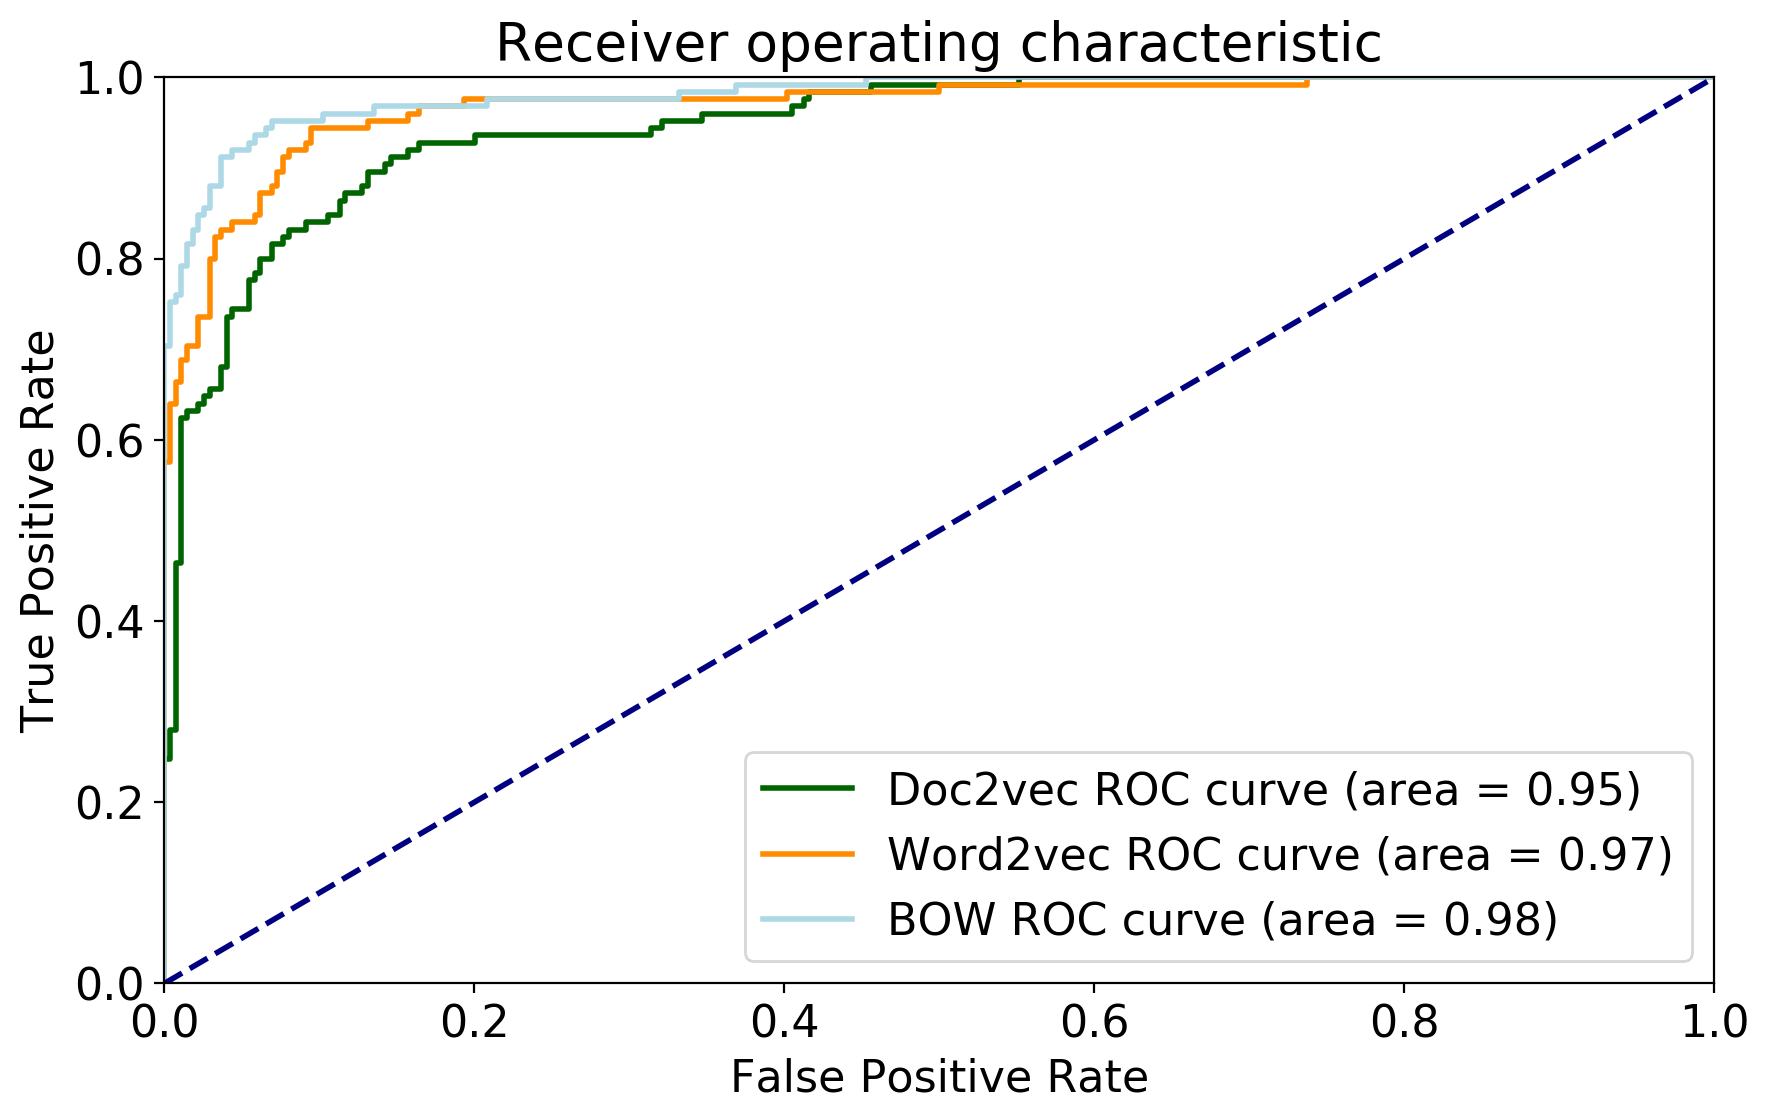

In [167]:
# Plot AUC

lw = 2
font = {'family': 'sans-serif', 'weight':'normal','size':16}
plt.rc('font',**font)

plt.figure(figsize=(10,6), dpi=200)

if d2v_run:
    plt.plot(fpr_d2v[0], tpr_d2v[0], color='darkgreen', lw=lw, label='Doc2vec ROC curve (area = %0.2f)' % roc_auc_d2v[0])
else:
    print("No D2V curve to display")
if w2v_run: 
    plt.plot(fpr_w2v[0], tpr_w2v[0], color='darkorange',lw=lw, label='Word2vec ROC curve (area = %0.2f)' % roc_auc_w2v[0])
else:
    print("No W2V curve to display")
if bow_run:
    plt.plot(fpr_bow[0], tpr_bow[0], color='lightblue', lw=lw, label='BOW ROC curve (area = %0.2f)' % roc_auc_bow[0])
else:
    print("No BOW curve to display")
# if w2v_d2v_run:
#     plt.plot(fpr_w2v_d2v[0], tpr_w2v_d2v[0], color='lightgrey', lw=lw, label='w2v+d2v ROC curve (area = %0.2f)' % roc_auc_w2v_d2v[0])
# else:
#     print("No w2v+d2v curve to display")

## Could try to do shaded area
# std_tpr = np.std(tprs, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)    
# ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                 label=r'$\pm$ 1 std. dev.')
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for'+results_matrix_test[0][1])
plt.legend(loc="lower right")

png_plot = plt.gcf()
plt.show()

plot_name='\\AUC'
if d2v_run: plot_name = plot_name+'_doc2vec'
if bow_run: plot_name = plot_name+'_bow'
if w2v_run: plot_name = plot_name+'_word2vec'
# if w2v_d2v_run: plot_name = plot_name+'_w2v+d2v'

time_tag = datetime.now().strftime("%Y%m%d%H%M%S")
plot_name = figures_path + plot_name+time_tag+'.png'

png_plot.savefig(plot_name)

    

In [70]:
# Visualize the array
def plot_embeddings(embeddings_array,DO_PARAGRAPH_VECTOR, DO_BOW, DO_WORD2VEC, figures_path):
    
    visualisation = 'umap'

    if visualisation == 'tsne':
        Model = TSNE(n_components=2)
    elif visualisation == 'umap':
        Model = umap.UMAP()

    low_dim_embedding = Model.fit_transform(embeddings_array)
    colors = ['r' if label == 1 else 'b' for label in Y]

    font = {'family': 'sans-serif', 'weight':'normal','size':16}
    plt.rc('font',**font)

    fig, ax = plt.subplots(figsize=(10,8))
    rounded_embedding = [[round(x[0], 4), round(x[1], 4)] for x in low_dim_embedding]
    ax.scatter(x=[x[0] for x in rounded_embedding], y=[x[1] for x in rounded_embedding], c = [C for C in colors],alpha = 0.3)
    ax.set_title("Low-dimensional visualisation of embeddings")

    png_plot = plt.gcf()
    plt.show()

    plot_name='\\embeddings'

    if DO_PARAGRAPH_VECTOR == True: plot_name = plot_name+'_doc2vec'
    if DO_BOW == True: plot_name = plot_name+'_bow'
    if DO_WORD2VEC == True: plot_name = plot_name+'_word2vec'

    time_tag = datetime.now().strftime("%Y%m%d%H%M%S")
    plot_name = figures_path + plot_name+time_tag+'.png'
    
    png_plot.savefig(plot_name)

    

c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


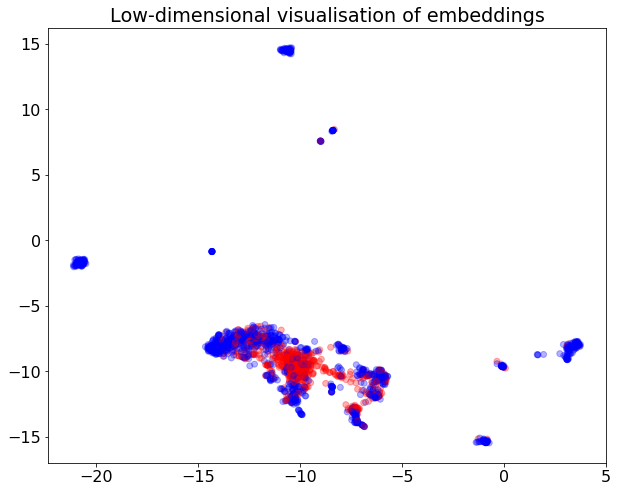

In [268]:
plot_embeddings(bow_matrix,DO_PARAGRAPH_VECTOR, DO_BOW, DO_WORD2VEC, figures_path)

In [125]:
auc_bars

[0    0.981
 Name: AUC, dtype: float64, 0    0.969
 Name: AUC, dtype: float64, 0    0.947
 Name: AUC, dtype: float64]

c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  # Remove the CWD from sys.path while we load stuff.
c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  # This is added back by InteractiveShellApp.init_path()
c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  if sys.path[0] == '':
c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  del sys.path[0]
c:\users\marti

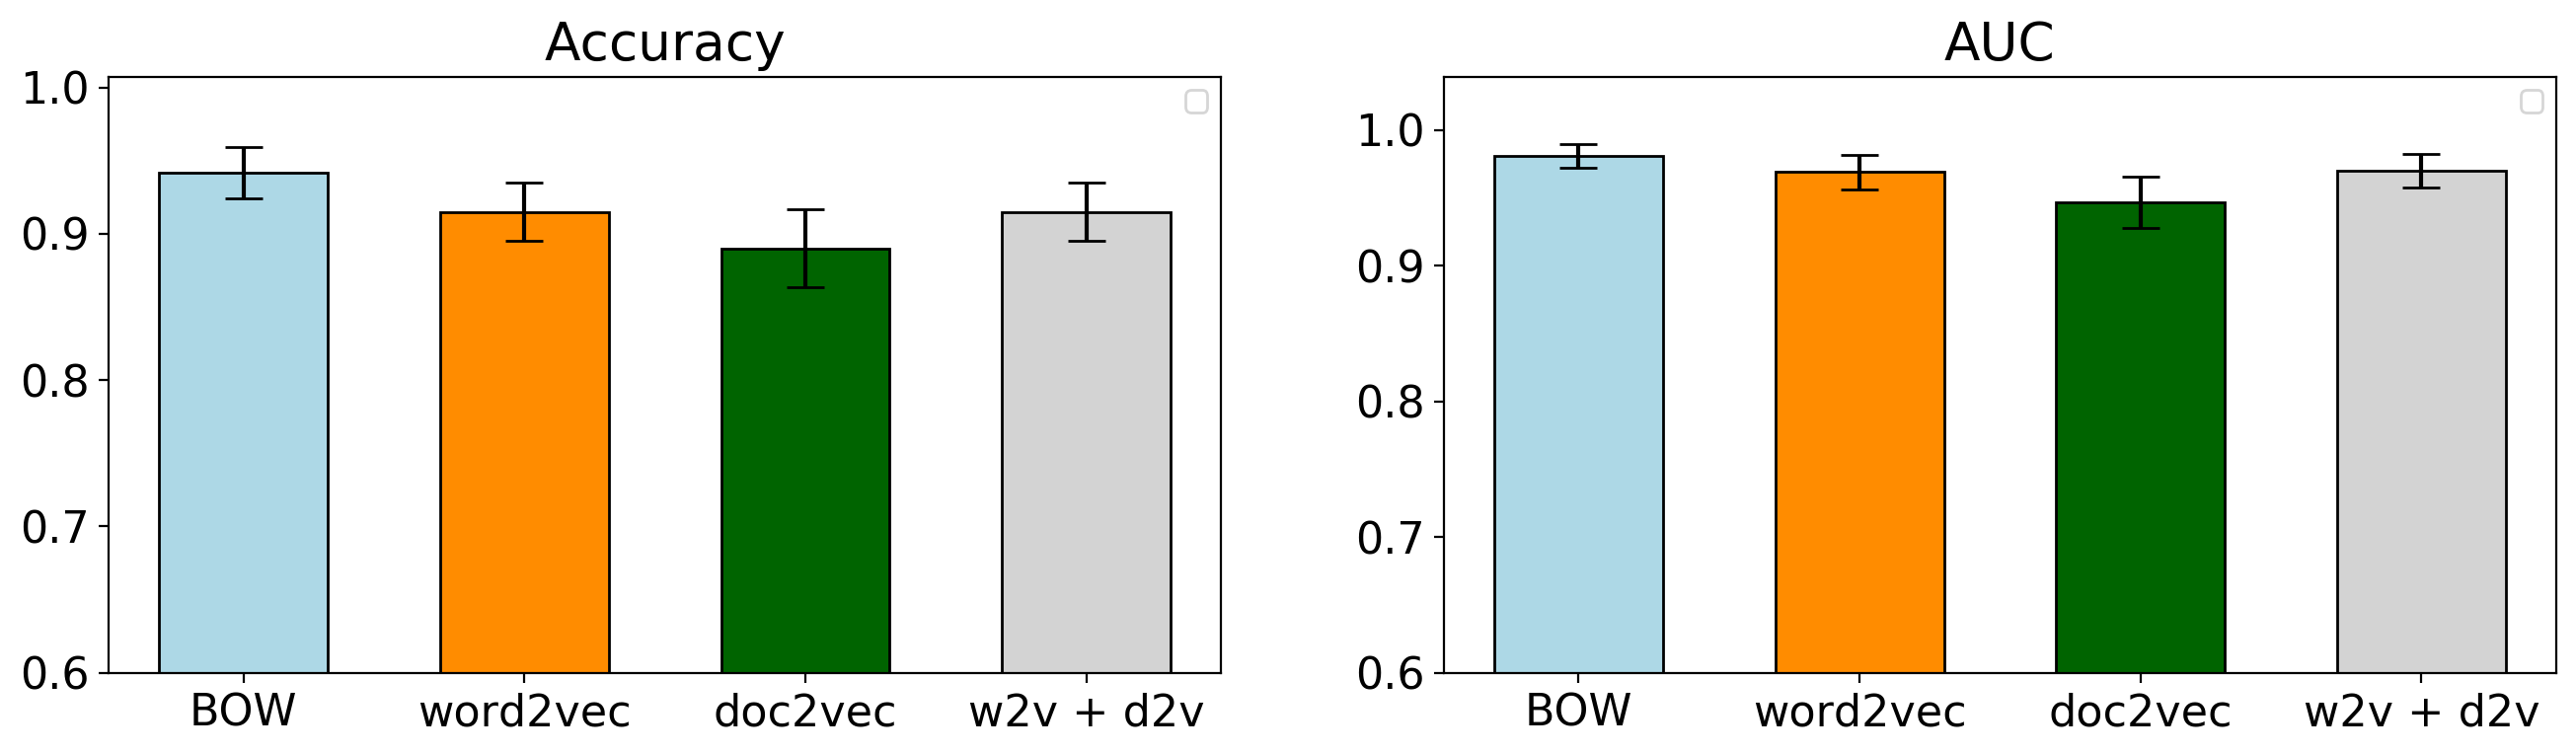

In [144]:
## Plot AUC & accuracy, adapted from https://python-graph-gallery.com/8-add-confidence-interval-on-barplot/

x_labels = ['BOW', 'word2vec', 'doc2vec','w2v + d2v']
# width of the bars
barWidth = 0.6
 
# Choose the height of the bars

auc_bars = []
auc_bars.append(np.asscalar(results_matrix_bow['AUC'].astype(float)))
auc_bars.append(np.asscalar(results_matrix_w2v['AUC'].astype(float)))
auc_bars.append(np.asscalar(results_matrix_d2v['AUC'].astype(float)))
auc_bars.append(np.asscalar(results_matrix_w2v_d2v['AUC'].astype(float)))


accuracy_bars = []
accuracy_bars.append(np.asscalar(results_matrix_bow['Accuracy'].astype(float)))
accuracy_bars.append(np.asscalar(results_matrix_w2v['Accuracy'].astype(float)))
accuracy_bars.append(np.asscalar(results_matrix_d2v['Accuracy'].astype(float)))
accuracy_bars.append(np.asscalar(results_matrix_w2v_d2v['Accuracy'].astype(float)))

#accuracy_bars = np.asarray([results_matrix_bow['Accuracy'].astype(float), results_matrix_w2v['Accuracy'].astype(float),results_matrix_d2v['Accuracy'].astype(float)])
# accuracy_bars = [1,3,1.5]
# auc_bars = [5,2,4]

# Choose the height of the error bars
auc_error = [(results_matrix_bow['AUC - Max'].astype(float)- results_matrix_bow['AUC - Min'].astype(float))/2, 
              (results_matrix_w2v['AUC - Max'].astype(float)- results_matrix_w2v['AUC - Min'].astype(float))/2, 
              (results_matrix_d2v['AUC - Max'].astype(float)- results_matrix_d2v['AUC - Min'].astype(float))/2,
              (results_matrix_w2v_d2v['AUC - Max'].astype(float) - results_matrix_w2v_d2v['AUC - Min'].astype(float))/2]
accuracy_error = [(results_matrix_bow['Accuracy - Max'].astype(float)- results_matrix_bow['Accuracy - Min'].astype(float))/2, 
                  (results_matrix_w2v['Accuracy - Max'].astype(float)- results_matrix_w2v['Accuracy - Min'].astype(float))/2, 
                  (results_matrix_d2v['Accuracy - Max'].astype(float)- results_matrix_d2v['Accuracy - Min'].astype(float))/2,
                  (results_matrix_w2v_d2v['Accuracy - Max'].astype(float)- results_matrix_w2v_d2v['Accuracy - Min'].astype(float))/2]

# Position of bars on X-axis
pos_auc = np.arange(len(auc_bars))
pos_accuracy = np.arange(len(accuracy_bars))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4), dpi=200)
ax0, ax1 = axes.flatten()
colors = ['lightblue', 'darkorange', 'darkgreen', 'lightgrey']

# Create accuracy bars
ax0.bar(x = pos_accuracy, height = accuracy_bars, width = barWidth, color = colors, edgecolor = 'black', yerr=accuracy_error, capsize=7, tick_label = x_labels)
ax0.legend(prop={'size':10})
# ax0.ylabel('Accuracy')
ax0.set_title('Accuracy')
# plt.xticks(x_labels)
ax0.set_ylim(bottom = 0.6)

# Create AUC bars
ax1.bar(x = pos_auc, height = auc_bars, width = barWidth, color = colors, edgecolor = 'black', yerr=auc_error, capsize=7, tick_label = x_labels)
ax1.legend(prop={'size': 10})
#ax1.ylabel('AUC')
ax1.set_title('AUC')
ax1.set_ylim(bottom = 0.6)


# plt.xticks([r + barWidth for r in range(len(auc_bars))],x_labels)

# for i, v in enumerate(x_labels):
#     ax0.text(i-.25, 
#               v/x_labels[i]+100, 
#               x_labels[i], 
#               fontsize=18, 
#               color=colors[i])

png_plot = plt.gcf()
plt.show()

plot_name='\\AUC_accuracy'
time_tag = datetime.now().strftime("%Y%m%d%H%M%S")
plot_name = figures_path + plot_name+time_tag+'.png'
png_plot.savefig(plot_name)






# Sinai Method

In [184]:
# Slight modifications to swap out indexing in TF FP TN FN and the randomization process
def calc_auc(predictor_matrix,eligible_outcomes_aligned, all_outcomes_aligned,N_LABELS, pred_type, header,ASSIGNFOLD_USING_ROW=False):

    train_proportion = 0.6
    lasso_models={}
    model_types = ["Lasso"]

    # shuffle the data
    eligible_outcomes_aligned.reindex(np.random.permutation(eligible_outcomes_aligned.index)) # swapped out np.random.shuffle(r)

    r = list(range(eligible_outcomes_aligned.shape[0]))
    np.random.shuffle(r)

    assignfold = pd.DataFrame(data=r, columns=['train'])
    cutoff = np.floor(train_proportion*eligible_outcomes_aligned.shape[0]).astype(int)

    train=assignfold['train']<cutoff
    test=assignfold['train']>=cutoff

    print(test)
    N_TRAIN=eligible_outcomes_aligned.iloc[:cutoff].shape[0]
    N_HELDOUT = eligible_outcomes_aligned.iloc[cutoff:].shape[0]

    #train = eligible_outcomes_aligned.iloc[:cutoff,[0]]
    #test = eligible_outcomes_aligned.iloc[cutoff:,[0]]

    print("n_train in modeling="+str(N_TRAIN))
    print("n_test in modeling="+str(N_HELDOUT))

    confusion = pd.DataFrame(data=np.zeros(shape=(eligible_outcomes_aligned.shape[1]*len(model_types),6),dtype=np.int),columns=['Label (with calcs on held out 40 pct)','AUC','True +','False +','True -','False -'])

    resultrow=0

    for i in range(0,N_LABELS):
            PROCEED=True;
            #need to make sure we don't have an invalid setting -- ie, a train[x] set of labels that is uniform, else Lasso regression fails
            if(len(set(eligible_outcomes_aligned.ix[train,i].tolist())))==1:
                PROCEED=False;
                raise ValueError ("fed label to lasso regression with no variation - cannot compute - please investigate data")

            if(PROCEED):

                for model_type in model_types:
                    if(model_type=="Lasso"):
                        parameters = { "penalty": ['l1'], 
                                       "C": [64,32,16,8,4,2,1,0.5,0.25,0.1,0.05,0.025,0.01,0.005]
                                     }
                        try:
                            cv = StratifiedKFold(n_splits=5)
                            grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid=parameters, scoring='neg_log_loss', cv=cv) ## can change liblinear to "lbfgs"
                            grid_search.fit(predictor_matrix[train,:],np.array(eligible_outcomes_aligned.ix[train,i]))				
                            best_parameters0 = grid_search.best_estimator_.get_params()
                            model0 = LogisticRegression(**best_parameters0)					
                        except:
                            raise ValueError ("error in lasso regression - likely data issue, may involve rare labels - please investigate data")                        
                    model0.fit(predictor_matrix[np.array(train),:],eligible_outcomes_aligned.ix[train,i])
                    pred0 = model0.predict_proba(predictor_matrix[np.array(test),:])[:,1]
                    coef = pd.concat([ pd.DataFrame(headers),pd.DataFrame(np.transpose(model0.coef_))], axis = 1)	
                    df0 = pd.DataFrame({'predict':pred0,'target':eligible_outcomes_aligned.ix[test,i], 'label':all_outcomes_aligned['Accession Number'][test]})

                    calc_auc=roc_auc_score(np.array(df0['target']),np.array(df0['predict']))
                    if(i%10==0):
                        print("i="+str(i))
                    save_name=str(list(eligible_outcomes_aligned.columns.values)[i])

                    target_predicted=''.join(e for e in save_name if e.isalnum())

                    #confusion: outcome TP TN FP FN
                    thresh = np.mean(df0['target'])
                    FP=0
                    FN=0
                    TP=0
                    TN=0
                    
                    # Added for computing ROC curve and ROC area
                    fpr = dict()
                    tpr = dict()
                    roc_auc = dict()
                    
                    prediction_list = df0[[0]].tolist()
                    target_list = df0[[1]].tolist()
                    
                    
                    fpr[0], tpr[0], thresholds = roc_curve(target_list, prediction_list)
                    roc_auc[0] = auc(fpr[0], tpr[0])

                                       # Compute micro-average ROC curve and ROC area
                    fpr["micro"], tpr["micro"], _ = roc_curve(target_list.ravel(), prediction_list.ravel())
                    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

                    for j in df0.index:
                        cpred = df0.ix[j][0] # changed from 1 to 0 
                        ctarget = df0.ix[j][1] # changed from 2 to 1

                        
                        if cpred>=thresh and ctarget==1:
                            TP+=1
                        if cpred<thresh and ctarget==1:
                            FN+=1
                        if cpred>=thresh and ctarget==0:
                            FP+=1
                        if cpred<thresh and ctarget==0:
                            TN+=1

                        
 

                    
                    #save results		
                    confusion.iloc[resultrow,0]=list(eligible_outcomes_aligned.columns.values)[i]
                    confusion.iloc[resultrow,1]=calc_auc
                    confusion.iloc[resultrow,2]=TP
                    confusion.iloc[resultrow,3]=FP
                    confusion.iloc[resultrow,4]=TN
                    confusion.iloc[resultrow,5]=FN

                    #let's rebuild model using all data before we save it to use for prediction;
                    try:
                        model0 = LogisticRegression(**best_parameters0)	
                        model0.fit(predictor_matrix,eligible_outcomes_aligned.ix[:,i])                
                        lasso_models[i]=model0
                    except:
                        raise ValueError ("error in lasso regression - likely data issue, may involve rare labels - please investigate data")                        

                    resultrow+=1

    confusion.set_index(confusion.columns[0],inplace=True)
    return lasso_models, confusion, fpr, tpr, roc_auc

In [185]:
# Create the lasso model using the function defined above
lasso_models, accuracy, fpr, tpr, roc_auc = calc_auc(predictor_matrix, eligible_outcomes_aligned,all_outcomes_aligned,N_LABELS, pred_type,headers,ASSIGNFOLD_USING_ROW) 

0        True
1        True
2       False
3       False
4        True
        ...  
1987     True
1988    False
1989     True
1990    False
1991    False
Name: train, Length: 1992, dtype: bool
n_train in modeling=1195
n_test in modeling=797


c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\pandas\core\indexing.py:961: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]
c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentatio

i=0


KeyError: "None of [Int64Index([0], dtype='int64')] are in the [columns]"

In [118]:
# Plot the ROC

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

0       False
1        True
2       False
3       False
4        True
        ...  
1150    False
1151     True
1152     True
1153    False
1154    False
Name: train, Length: 1155, dtype: bool
n_train in modeling=693
n_test in modeling=462


c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\pandas\core\indexing.py:961: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]
c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentatio

i=0


c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\ipykernel_launcher.py:98: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


In [119]:
inferred_binary_labels, inferred_proba_labels = ra.write_silver_standard_labels(corpus,
                                                  N_LABELS,
                                                  eligible_outcomes_aligned, 
                                                  DIM_DOC2VEC, 
                                                  preprocessed, 
                                                  DO_BOW, 
                                                  DO_PARAGRAPH_VECTOR, 
                                                  DO_WORD2VEC, 
                                                  dictionary, 
                                                  d2vmodel, 
                                                  d2v_inputs, 
                                                  lasso_models_ra, 
                                                  accid_list, 
                                                  labeled_indices, 
                                                  df_raw_filter, 
                                                  SILVER_THRESHOLD)

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70it/s]
C:\Users\marti\Dropbox\1. KCL\1. Current Modules\6. SPM\1. Analysis\NLP\rad-report-annotator\RadReportAnnotator.py:798: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if(eligible_outcomes_aligned.ix[outcome_lookup[accno],k]!=pred_outcome_binary_df.iloc[i,k]):
c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\pandas\core\indexing.py:961: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]
C:\Users\marti\Dropbox\1. KCL\1. 

In [120]:
lasso_models_ra
accuracy


,AUC,True +,False +,True -,False -
Label (with calcs on held out 40 pct),,,,,
Mass,0.959194,195,34,213,20


In [127]:
# 	def define_config(self, DO_BOW=True, DO_WORD2VEC=False, DO_PARAGRAPH_VECTOR=False,DO_SILVER_STANDARD=True,STEM_WORDS=True,N_GRAM_SIZES=[1],DIM_DOC2VEC=200,N_THRESH_CORPUS=1,N_THRESH_OUTCOMES=1,TRAIN_INDEX_OVERRIDE=[], SILVER_THRESHOLD="mean", NAME_UNID_REPORTS="Accession Number",NAME_TEXT_REPORTS="Report Text"):
# 		"""
# 		Sets parameters for RadReportAnnotator.
# 		Args:
# 			DO_BOW: True to use indicator bag of words-based features (1 if word present in doc, 0 if not). 
# 			DO_WORD2VEC: True to use word2vec-based average word embedding fatures. 
# 			DO_PARAGRAPH_VECTOR: True to use word2vec-based paragraph vector embedding fatures. 
# 			DO_SILVER_STANDARD: True to infer labels for unlabeled reports.
# 			STEM_WORDS: True to stem words for BOW analysis; words are unstemmed in doc2vec analysis
# 			N_GRAM_SIZES: Which set of n-grams to use in BOW analysis: [1] = 1 grams only, [3] = 3 grams only, [1,2,3] = 1, 2, and 3- grams.
# 			DIM_DOC2VEC: Dimensionality of doc2vec manifold; recommend value in 50 to 400
# 			N_THRESH_CORPUS: ignore any n-grams that appear fewer than N times in the entire corpus
# 			N_THRESH_OUTCOMES: do not train models for labels that don't have at least this many positive and negative examples. 
# 			TRAIN_INDEX_OVERRIDE: list of accession numbers we force to be treated as unlabeled data even though they are labeled (ie, these will *not* be used in Lasso regressions). May be used if all of your reports are labeled, as some unlabeled reports are required for d2v training.
# 			SILVER_THRESHOLD: how to threshold probability predictions in infer_labels to get binary labels. 
# 			                  can be ["mean","mostlikely"]
# 			                  mean sets any predicted probability greater than population mean to 1, else 0; e.g., prediction 0.10 in a label with average 0.05 is set to 1
# 			                  mostlikely sets any predicted probability >50% to 1, otherwise 0
# 			                  both settings have issues, and class imbalance is a major issue in training convolutional nets.
# 			                  we recommend using probabilities if your model can accomodate it. 
#  			NAME_UNID_REPORTS: column name of accession number / unique report id in the read-in *reports* file. provided for convenience as there may be many report files.
# 			NAME_TEXT_REPORTS: column name of report text in the read-in reports file. provided for convenience as there may be many report files.
# 		Returns:
# 			Nothing
# 		"""

# 		self.DO_BOW=DO_BOW #generate results for bag of words approach?
# 		self.DO_WORD2VEC=DO_WORD2VEC #generate resultes (tfidf and avg weight) for word2vec approach?
# 		self.DO_PARAGRAPH_VECTOR=DO_PARAGRAPH_VECTOR #generate results for paragraph vector approach?
# 		self.DO_SILVER_STANDARD=DO_SILVER_STANDARD	#generate silver standard labels?
# 		self.STEM_WORDS=STEM_WORDS #should we stem words for BOW, LDA analysis? (we never stem words or doc2vec/w2v analysis, see below)
# 		if not N_GRAM_SIZES in ([1],[2],[3],[1,2],[1,3],[1,2,3]):
# 			raise ValueError('Invalid N_GRAM_SIZES argument:'+str(N_GRAM_SIZES)+", please review documentation for proper format (e.g., [1])")
# 		self.N_GRAM_SIZES = N_GRAM_SIZES  # how many n-grams to use in BOW, LDA analyses? [1] = 1 grams only, [3] = 3 grams only, [1,2,3] = 1, 2, and 3- grams.
# 		self.DIM_DOC2VEC = DIM_DOC2VEC #dimensionality of doc2vec manifold
# 		self.N_THRESH_CORPUS=N_THRESH_CORPUS # delete any n-grams that appear fewer than N times in the entire corpus
# 		self.N_THRESH_OUTCOMES=N_THRESH_OUTCOMES # delete any predictors that don't have at least N-many positive and negative examples
# 		self.TRAIN_INDEX_OVERRIDE = TRAIN_INDEX_OVERRIDE # define a list of indices you want to force to be included as unlabeled data even though they are labeled (ie, these will *not* be used for predictions). Some unlabeled reports are required for d2v training."""
# 		self.SILVER_THRESHOLD=SILVER_THRESHOLD
# 		self.NAME_UNID_REPORTS = NAME_UNID_REPORTS  
# 		self.NAME_TEXT_REPORTS = NAME_TEXT_REPORTS

# 		if(self.DO_BOW==False and self.DO_WORD2VEC==False and self.DO_PARAGRAPH_VECTOR==False): raise ValueError("DO_BOW and DO_WORD2VEC and DO_PARAGRAPH_VECTOR cannot both be false")


In [129]:
# 	def infer_labels(self):
# 		"""
# 		Infers labels for unlabeled documents.
# 		Please run build_corpus() beforehand.
# 		Arguments:
# 			None
# 		Returns:
# 			self.inferred_labels: dataframe containing inferred labels
# 		"""

# 		#get the numerical features of text we need to train models for labels
# 		self.bow_matrix, self.pv_matrix,self.w2v_matrix,self.accid_list,self.orig_text,self.orig_input=generate_labeled_data_features(
# 							   self.validation_file,
# 							   self.labeled_indices,
# 							   self.DIM_DOC2VEC,
# 							   self.df_data,
# 							   self.processed_reports,
# 							   self.DO_PARAGRAPH_VECTOR,
# 							   self.DO_WORD2VEC, 
# 							   self.dictionary,
# 							   self.corpus,
# 							   self.d2vmodel,
# 							   self.d2v_inputs)

# 		#get and process labels for reports
# 		self.eligible_outcomes_aligned,self.all_outcomes_aligned, self.N_LABELS, self.outcome_header_list = generate_outcomes(
# 			self.validation_file,
# 			self.accid_list,
# 			self.N_THRESH_OUTCOMES)

# 		#to generate silver standard labels -- use whatever features are generated (word2vec average word embeddings, bow features, paragraph vector matrix)
# 		if(self.DO_BOW and self.DO_WORD2VEC and self.DO_PARAGRAPH_VECTOR): self.combined=np.hstack((self.bow_matrix,self.w2v_matrix,self.pv_matrix))

# 		if(self.DO_BOW and self.DO_WORD2VEC and not self.DO_PARAGRAPH_VECTOR): self.combined=np.hstack((self.bow_matrix,self.w2v_matrix))
# 		if(self.DO_BOW and not self.DO_WORD2VEC and self.DO_PARAGRAPH_VECTOR): self.combined=np.hstack((self.bow_matrix,self.pv_matrix))
# 		if(not self.DO_BOW and self.DO_WORD2VEC and self.DO_PARAGRAPH_VECTOR): self.combined=np.hstack((self.w2v_matrix,self.pv_matrix))

# 		if(self.DO_BOW and not self.DO_WORD2VEC and not self.DO_PARAGRAPH_VECTOR): self.combined=self.bow_matrix
# 		if(not self.DO_BOW and self.DO_WORD2VEC and not self.DO_PARAGRAPH_VECTOR): self.combined=self.w2v_matrix
# 		if(not self.DO_BOW and not self.DO_WORD2VEC and self. DO_PARAGRAPH_VECTOR): self.combined=self.pv_matrix		

# 		#create header for combined predictor matrix so we can interpret coefficients
# 		self.headers=[]
# 		if(self.DO_BOW): 				self.headers=self.headers + [self.dictionary[i] for i in self.dictionary]
# 		if(self.DO_WORD2VEC): 			self.headers=self.headers + ["W2V"+str(i) for i in range(0,self.DIM_DOC2VEC)]
# 		if(self.DO_PARAGRAPH_VECTOR): 	self.headers=self.headers + ["PV"+str(i) for i in range(0,self.DIM_DOC2VEC)]


# 		pred_type = "combined" # a label for results
# 		print("dimensionality of predictor matrix:"+str(self.combined.shape))

# 		#run lasso regressions
# 		self.lasso_models, self.accuracy = calc_auc(self.combined,self.eligible_outcomes_aligned,self.all_outcomes_aligned,  self.N_LABELS, pred_type, self.headers,self.ASSIGNFOLD_USING_ROW)

# 		#infer labels	
# 		self.inferred_binary_labels, self.inferred_proba_labels = write_silver_standard_labels(self.corpus,
# 			self.N_LABELS,
# 			self.eligible_outcomes_aligned,
# 			self.DIM_DOC2VEC,
# 			self.processed_reports,
# 			self.DO_BOW,
# 			self.DO_PARAGRAPH_VECTOR,
# 			self.DO_WORD2VEC,
# 			self.dictionary,
# 			self.d2vmodel,
# 			self.d2v_inputs,
# 			self.lasso_models,
# 			self.accid_list, 
# 			self.labeled_indices,
# 			self.df_data,
# 			self.SILVER_THRESHOLD)
# 		return self.inferred_binary_labels, self.inferred_proba_labels

In [130]:
# This works, but not as elegant

# if predictor_matrix.shape[1]!=len(header):
#     print("predictor_matrix.shape[1]="+str(predictor_matrix.shape[1]))
#     print("len(header)"+str(len(header)))
#     raise ValueError("predictor_matrix shape doesn't match header, investigate")
# all_coef = pd.concat([ pd.DataFrame(header)], axis = 1)	



# train_proportion = 0.6
# lasso_models={}
# model_types = ["Lasso"]

# # shuffle the data
# eligible_outcomes_aligned.reindex(np.random.permutation(eligible_outcomes_aligned.index)) # swapped out np.random.shuffle(r)

# r = list(range(eligible_outcomes_aligned.shape[0]))
# np.random.shuffle(r)

# assignfold = pd.DataFrame(data=r, columns=['train'])
# cutoff = np.floor(train_proportion*eligible_outcomes_aligned.shape[0]).astype(int)

# train=assignfold['train']<cutoff
# test=assignfold['train']>=cutoff

# print(test)
# N_TRAIN=eligible_outcomes_aligned.iloc[:cutoff].shape[0]
# N_HELDOUT = eligible_outcomes_aligned.iloc[cutoff:].shape[0]

# #train = eligible_outcomes_aligned.iloc[:cutoff,[0]]
# #test = eligible_outcomes_aligned.iloc[cutoff:,[0]]

# print("n_train in modeling="+str(N_TRAIN))
# print("n_test in modeling="+str(N_HELDOUT))

# confusion = pd.DataFrame(data=np.zeros(shape=(eligible_outcomes_aligned.shape[1]*len(model_types),6),dtype=np.int),columns=['Label (with calcs on held out 40 pct)','AUC','True +','False +','True -','False -'])

# resultrow=0
# i = 0

# parameters = { "penalty": ['l1'], 
#                "C": [64,32,16,8,4,2,1,0.5,0.25,0.1,0.05,0.025,0.01,0.005]}

# cv = StratifiedKFold(n_splits=5)
# grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid=parameters, scoring='neg_log_loss', cv=cv) ## can change liblinear to "lbfgs"
# grid_search.fit(predictor_matrix[train,:],np.array(eligible_outcomes_aligned.ix[train,i]))				
# best_parameters0 = grid_search.best_estimator_.get_params()
# model0 = LogisticRegression(**best_parameters0)					
                 
# model0.fit(predictor_matrix[np.array(train),:],eligible_outcomes_aligned.ix[train,i])
# pred0=model0.predict_proba(predictor_matrix[np.array(test),:])[:,1]
# coef = pd.concat([ pd.DataFrame(headers),pd.DataFrame(np.transpose(model0.coef_))], axis = 1)	
# df0 = pd.DataFrame({'predict':pred0,'target':eligible_outcomes_aligned.ix[test,i], 'label':all_outcomes_aligned['Accession Number'][test]})

# calc_auc=roc_auc_score(np.array(df0['target']),np.array(df0['predict']))
# save_name=str(list(eligible_outcomes_aligned.columns.values)[i])
# target_predicted=''.join(e for e in save_name if e.isalnum())

# # confusion: outcome TP TN FP FN
# thresh = np.mean(df0['target'])
# FP=0
# FN=0
# TP=0
# TN=0

# for j in df0.index:
#     cpred=df0.ix[j][0]
#     ctarget = df0.ix[j][1]

#     if cpred>=thresh and ctarget==1:
#         TP+=1
#     if cpred<thresh and ctarget==1:
#         FN+=1
#     if cpred>=thresh and ctarget==0:
#         FP+=1
#     if cpred<thresh and ctarget==0:
#         TN+=1
						
# #save results		
# confusion.iloc[resultrow,0]=list(eligible_outcomes_aligned.columns.values)[i]
# confusion.iloc[resultrow,1]=calc_auc
# confusion.iloc[resultrow,2]=TP
# confusion.iloc[resultrow,3]=FP
# confusion.iloc[resultrow,4]=TN
# confusion.iloc[resultrow,5]=FN
            
    
# model0 = LogisticRegression(**best_parameters0)	
# model0.fit(predictor_matrix,eligible_outcomes_aligned.ix[:,i])                
# lasso_models[i]=model0

# # resultrow+=1

# confusion.set_index(confusion.columns[0],inplace=True)
# # return lasso_models, confusion